In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
u_samp = np.loadtxt("Results/uniform_sampling.dat")

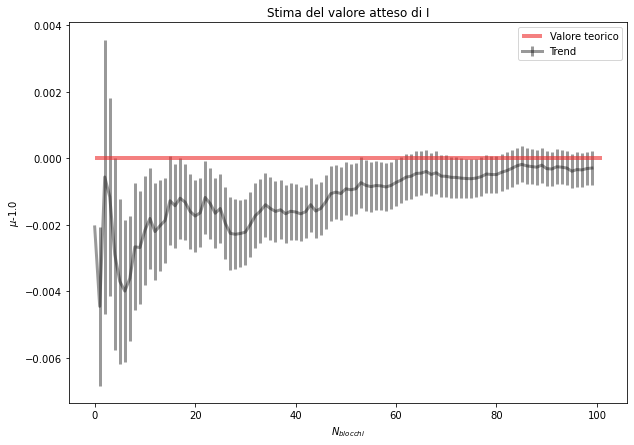

In [18]:
x = np.arange(100)

plt.figure(figsize=(10,7))

plt.title("Stima del valore atteso di I")
plt.errorbar(x, u_samp.T[0]-1, yerr=u_samp.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.show()